Necessary Code to use Kaggle Dataset on Google Colab


In [1]:
!pip install opendatasets
!pip install pandas

In [2]:
import opendatasets as od
import pandas

In [3]:
od.download(
    "https://www.kaggle.com/datasets/sabahesaraki/breast-ultrasound-images-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mainak0907
Your Kaggle Key: ··········


100%|██████████| 195M/195M [00:01<00:00, 104MB/s]


Importing Necessay Library for Implementation

In [4]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

Data Loading


In [5]:
## defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)

    names = []
    maskNames = []
    unames = []

    for i in range(len(imgNames)):
        unames.append(imgNames[i].split(')')[0])

    unames = list(set(unames))

    for i in range(len(unames)):
        names.append(unames[i]+').png')
        maskNames.append(unames[i]+')_mask.png')

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])

        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))

        frameObj['img'].append(img)
        frameObj['mask'].append(mask)

    return frameObj

In [6]:
# loading benign samples

framObjTrain = LoadData( framObjTrain, imgPath = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign'
                        , maskPath = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign'
                         , shape = 256)

In [7]:
# loading malignant samples

framObjTrain = LoadData( framObjTrain, imgPath = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant'
                        , maskPath = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant'
                         , shape = 256)

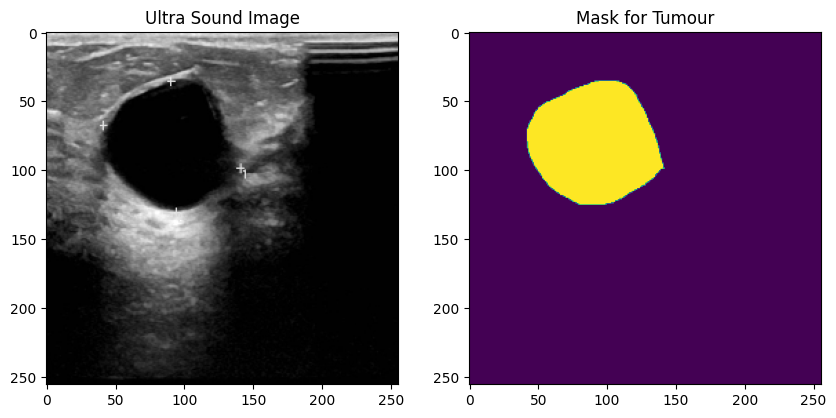

In [8]:
## displaying data loaded by our function
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][2])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][2])
plt.title('Mask for Tumour')
plt.show()

Model Defination


In [9]:
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x

In [10]:
# Now defining Unet
def Unet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)

    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [11]:
## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = Unet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

Training for 50 Epochs

In [13]:
retVal = myTransformer.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 50, verbose = 1)

Epoch 1/50
21/21 [==============================] - 499s 23s/step - loss: 0.3741 - accuracy: 0.9110
Epoch 2/50
21/21 [==============================] - 492s 23s/step - loss: 0.3398 - accuracy: 0.9121
Epoch 3/50
21/21 [==============================] - 488s 23s/step - loss: 0.3166 - accuracy: 0.9129
Epoch 4/50
21/21 [==============================] - 482s 23s/step - loss: 0.3097 - accuracy: 0.9104
Epoch 5/50
21/21 [==============================] - 490s 23s/step - loss: 0.2795 - accuracy: 0.9156
Epoch 6/50
21/21 [==============================] - 488s 23s/step - loss: 0.2627 - accuracy: 0.9204
Epoch 7/50
21/21 [==============================] - 488s 23s/step - loss: 0.2433 - accuracy: 0.9254
Epoch 8/50
21/21 [==============================] - 488s 23s/step - loss: 0.2331 - accuracy: 0.9276
Epoch 9/50
21/21 [==============================] - 483s 23s/step - loss: 0.2225 - accuracy: 0.9277
Epoch 10/50
21/21 [==============================] - 485s 23s/step - loss: 0.2023 - accuracy: 0.9348

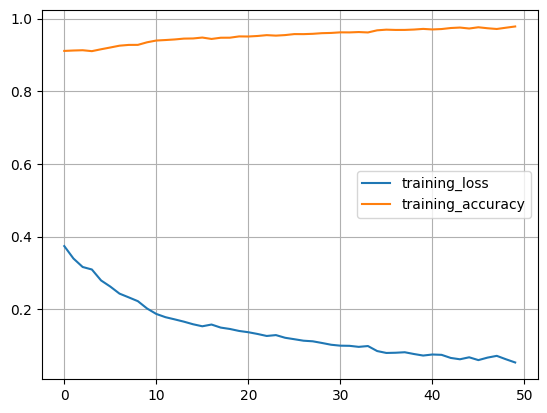

In [14]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

Testing


In [15]:
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    #mask = mask[0:16]

    imgProc = img [0:16]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)


    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(' image')

    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted mask')

    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual mask')

1/1 [==============================] - 4s 4s/step


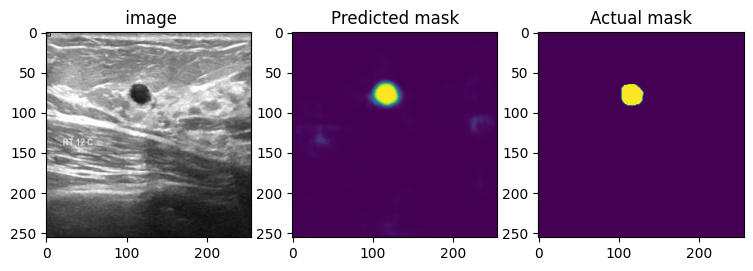

In [16]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, myTransformer)
Plotter(actuals[1], sixteenPrediction[1][:,:,0], masks[1])

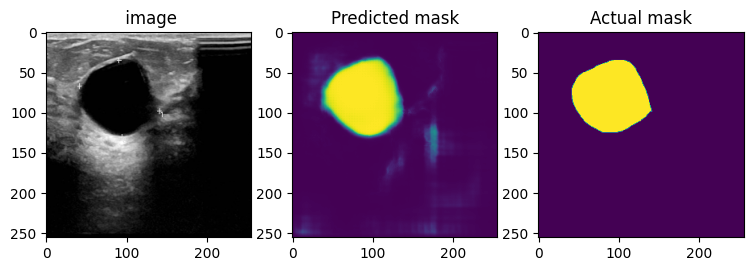

In [17]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

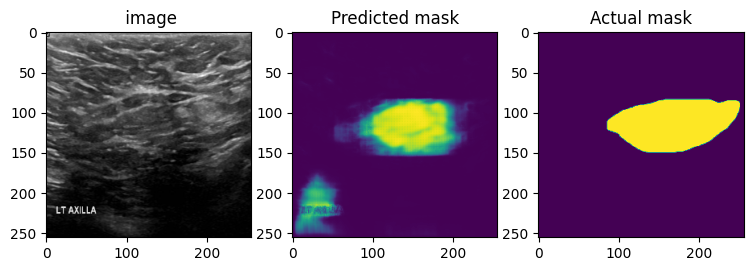

In [18]:
Plotter(actuals[3], sixteenPrediction[3][:,:,0], masks[3])

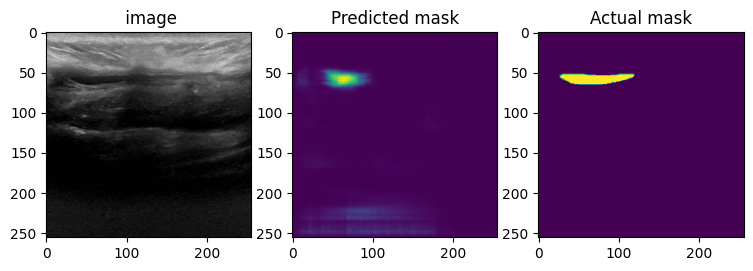

In [19]:
Plotter(actuals[5], sixteenPrediction[5][:,:,0], masks[5])

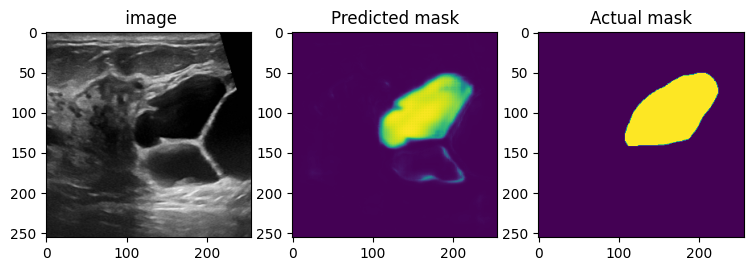

In [20]:
Plotter(actuals[7], sixteenPrediction[7][:,:,0], masks[7])

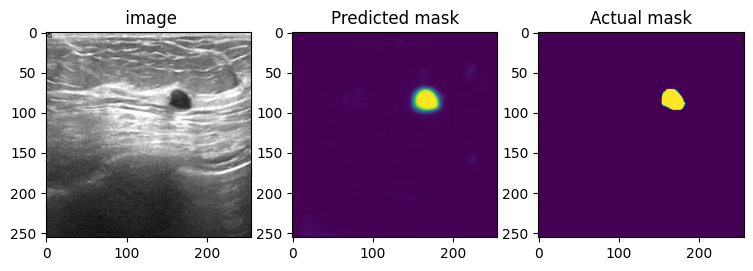

In [21]:
Plotter(actuals[8], sixteenPrediction[8][:,:,0], masks[8])

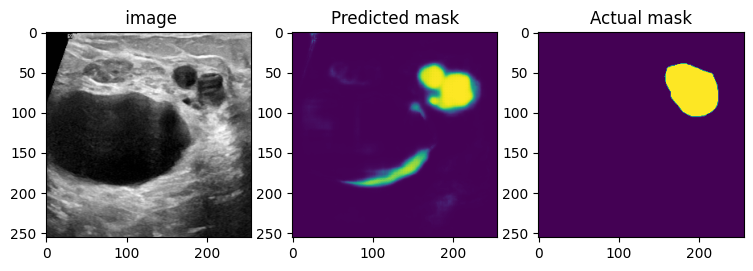

In [22]:
Plotter(actuals[9], sixteenPrediction[9][:,:,0], masks[9])


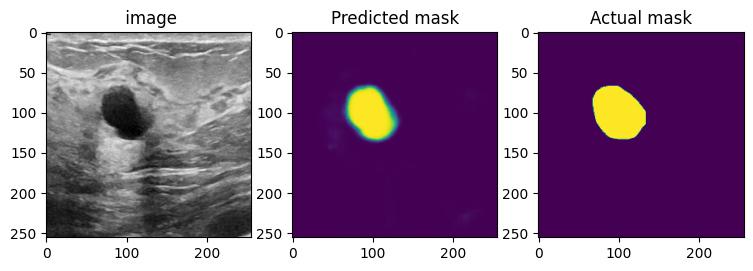

In [23]:
Plotter(actuals[10], sixteenPrediction[10][:,:,0], masks[10])

In [24]:
myTransformer.save('BreastCancerSegmentor.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
